In [1]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
# base logger setup, to standardize logging across classes
try:
    logger.debug('testing logger')
except:
    name = 'SGAN'
    formatter = logging.Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)
    
def create_generator(n_real_inputs, n_hidden_nodes, n_fake_inputs):
    inputs = Input(shape=[n_fake_inputs])
    dense_layer0 = Dense(n_hidden_nodes, kernel_initializer='glorot_normal')(inputs)
    activation_layer0 = Activation('relu')(dense_layer0)
    dense_layer1 =  Dense(n_real_inputs, kernel_initializer='glorot_normal')(activation_layer0) 
    outputs = Activation('sigmoid')(dense_layer1)
    generator = Model(inputs, outputs)
    generator.compile(loss='categorical_crossentropy', optimizer='adam')
    return generator

def create_discriminator(n_real_inputs, n_hidden_nodes, n_outputs, dropout_rate):
    inputs = Input(shape=[n_real_inputs])
    noise = GaussianNoise(.2)(inputs)
    dense_layer0 = Dense(n_hidden_nodes, kernel_initializer='glorot_normal')(noise)
    activation_layer0 = Activation('relu')(dense_layer0)
    drop0 = Dropout(dropout_rate)(activation_layer0)
    dense_layer1 =  Dense(n_outputs + 1, kernel_initializer='glorot_normal')(drop0) 
    outputs = Activation('sigmoid')(dense_layer1)
    discriminator  = Model(inputs, outputs)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return discriminator

# Create a stacked version of the model with the generator wieghts frozen
def create_stacked_model(generator, discriminator):
    stacked_model = Sequential()
    generator.trainable = False
    stacked_model.add(generator)
    stacked_model.add(discriminator)
    stacked_model.compile(loss='categorical_crossentropy', optimizer='adam')
    return stacked_model


# define the training functions
def create_training_data(X_train, y_train, generator, batch=10):
    n_obs, n_inputs = X_train.shape
    half_batch = int(batch/2)
    n_fake_inputs = generator.get_input_shape_at(0)[1]
    
    # randomly sample real data 
    index =  np.random.randint(0, n_obs, half_batch)
    real_data = X_train[index, :]
    real_class_labels = y_train[index, :]
    
    # generate fake data 
    noise = np.random.uniform(0, 1, (half_batch, n_fake_inputs))
    fake_data =  generator.predict(noise)
    
    # stack real and fake data 
    combined_data = np.concatenate((real_data, fake_data))
    
    #pad labels with zero rows
    labels_padded = np.vstack((real_class_labels, np.zeros(real_class_labels.shape)))
    logger.debug('labels padded shape {}'.format(labels_padded.shape))
    
    # create the real vs fake label
    real_fake_labels = np.reshape(np.append(np.zeros(half_batch), np.ones(half_batch)), (-1,1))
    logger.debug('real vs fake_labels {}'.format(real_fake_labels.shape))
    
    labels = np.hstack((labels_padded, real_fake_labels))
    
    logger.debug('real data shape {}'.format(real_data.shape))
    logger.debug('labels shape {}'.format(labels.shape))
    logger.debug('fake data shape {}'.format(fake_data.shape))

    return real_data, fake_data, labels 

def get_miss_labeled(noise):
    output = to_categorical(np.argmax(noise, axis=1))
    logger.debug(output.shape)
    return np.hstack((output, np.zeros((noise.shape[0], 1))))


# primary training functions
def training(X_train, y_train, generator, discriminator, epochs=10, batch=10):
    # create the stacked model
    stacked_model = create_stacked_model(generator, discriminator)
    
    # get the input data shape
    n_obs, n_inputs = X_train.shape
    half_batch = int(batch/2)
    n_fake_inputs = generator.get_input_shape_at(0)[1]
    n_outputs = y_train.shape[1]
    for e in range(epochs):
        real_data, fake_data, labels = create_training_data(X_train, y_train, generator, batch)
        combined_data = np.concatenate((real_data, fake_data))

        # discriminator loss 
        disc_loss = discriminator.train_on_batch(combined_data, labels)
        
        # create noise to 
        noise =  np.random.uniform(0, 1, (batch, n_fake_inputs))
        
        # create misslabeled data to force the stack model to learn
        y_mislabled =  get_miss_labeled(noise)
    
        # genertor loss 
        gen_loss = stacked_model.train_on_batch(x=noise,y=y_mislabled)
        logger.info('epoch:{0}/{1}, disc_loss: {2}, gen_loss:{3}'.format(e, epochs, disc_loss, gen_loss))

    generator = stacked_model.layers[0]
    discriminator = stacked_model.layers[1]
    return generator, discriminator


C:\Python36\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

noise =  np.random.normal(0, 1, (5, 3))
get_miss_labeled(noise)

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [3]:
X_train = load_iris()['data']
scaler = StandardScaler().fit(X_train )
X = scaler.transform(X_train)
y = to_categorical(load_iris()['target'])  ## one hot encodes the integer classes 
feature_names = load_iris()['feature_names'] 
class_names = list(load_iris()['target_names'])
logger.info('X shape {}'.format(X.shape))
logger.info('y shape {}'.format(y.shape))
print(class_names)

2019-10-07 12:46:34,505 - SGAN - INFO - X shape (150, 4)
2019-10-07 12:46:34,507 - SGAN - INFO - y shape (150, 3)


['setosa', 'versicolor', 'virginica']


In [4]:
#num columns in input data
n_real_inputs = X.shape[1]

# number of class labels
n_outputs = y.shape[1]

# length of array used to generate examples
n_fake_inputs = n_outputs 

# number of hidden nodes in distriminator and generator
n_hidden_nodes = 20

batch = 50
epochs = 100

# define generator
generator = create_generator(n_real_inputs, n_hidden_nodes, n_fake_inputs)
generator.summary()

# define discriminator
discriminator = create_discriminator(n_real_inputs, n_hidden_nodes, n_outputs, dropout_rate=.1 )
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 84        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (Inp

In [5]:
stacked_model = create_stacked_model(generator, discriminator)
stacked_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4)                 164       
_________________________________________________________________
model_2 (Model)              (None, 4)                 184       
Total params: 348
Trainable params: 184
Non-trainable params: 164
_________________________________________________________________


In [6]:
## Test out the training creation Function
real_data, fake_data, labels = create_training_data(X, y, generator, batch=10)
pd.DataFrame(labels, columns =class_names + ['real_or_fake'])

,setosa,versicolor,virginica,real_or_fake
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0


In [7]:
generator, discriminator  = training(X, y, generator, discriminator,  epochs=1000, batch=50)

2019-10-07 12:46:40,953 - SGAN - INFO - epoch:0/1000, disc_loss: [1.415628, 0.22], gen_loss:1.3967829942703247
2019-10-07 12:46:40,964 - SGAN - INFO - epoch:1/1000, disc_loss: [1.3807057, 0.24], gen_loss:1.396376132965088
2019-10-07 12:46:40,976 - SGAN - INFO - epoch:2/1000, disc_loss: [1.3625193, 0.3], gen_loss:1.4073272943496704
2019-10-07 12:46:40,987 - SGAN - INFO - epoch:3/1000, disc_loss: [1.3731836, 0.42], gen_loss:1.3911834955215454
2019-10-07 12:46:40,998 - SGAN - INFO - epoch:4/1000, disc_loss: [1.3399369, 0.4], gen_loss:1.3918371200561523
2019-10-07 12:46:41,011 - SGAN - INFO - epoch:5/1000, disc_loss: [1.3928894, 0.26], gen_loss:1.3976556062698364
2019-10-07 12:46:41,022 - SGAN - INFO - epoch:6/1000, disc_loss: [1.3979622, 0.2], gen_loss:1.3996831178665161
2019-10-07 12:46:41,035 - SGAN - INFO - epoch:7/1000, disc_loss: [1.3668716, 0.32], gen_loss:1.383785605430603
2019-10-07 12:46:41,046 - SGAN - INFO - epoch:8/1000, disc_loss: [1.4050668, 0.24], gen_loss:1.408221006393432

2019-10-07 12:46:41,786 - SGAN - INFO - epoch:73/1000, disc_loss: [1.3088833, 0.3], gen_loss:1.3939491510391235
2019-10-07 12:46:41,797 - SGAN - INFO - epoch:74/1000, disc_loss: [1.2568195, 0.38], gen_loss:1.3874355554580688
2019-10-07 12:46:41,809 - SGAN - INFO - epoch:75/1000, disc_loss: [1.2654632, 0.36], gen_loss:1.3963884115219116
2019-10-07 12:46:41,821 - SGAN - INFO - epoch:76/1000, disc_loss: [1.2973552, 0.34], gen_loss:1.3906104564666748
2019-10-07 12:46:41,832 - SGAN - INFO - epoch:77/1000, disc_loss: [1.2703485, 0.46], gen_loss:1.3674664497375488
2019-10-07 12:46:41,843 - SGAN - INFO - epoch:78/1000, disc_loss: [1.2933964, 0.34], gen_loss:1.3601784706115723
2019-10-07 12:46:41,854 - SGAN - INFO - epoch:79/1000, disc_loss: [1.2742647, 0.36], gen_loss:1.3690353631973267
2019-10-07 12:46:41,865 - SGAN - INFO - epoch:80/1000, disc_loss: [1.2781036, 0.46], gen_loss:1.3841848373413086
2019-10-07 12:46:41,877 - SGAN - INFO - epoch:81/1000, disc_loss: [1.2853601, 0.44], gen_loss:1.3

2019-10-07 12:46:42,621 - SGAN - INFO - epoch:146/1000, disc_loss: [1.215355, 0.42], gen_loss:1.3945627212524414
2019-10-07 12:46:42,632 - SGAN - INFO - epoch:147/1000, disc_loss: [1.1877222, 0.52], gen_loss:1.3801368474960327
2019-10-07 12:46:42,643 - SGAN - INFO - epoch:148/1000, disc_loss: [1.2405707, 0.4], gen_loss:1.4067637920379639
2019-10-07 12:46:42,655 - SGAN - INFO - epoch:149/1000, disc_loss: [1.2358345, 0.44], gen_loss:1.3730868101119995
2019-10-07 12:46:42,666 - SGAN - INFO - epoch:150/1000, disc_loss: [1.19626, 0.44], gen_loss:1.3861027956008911
2019-10-07 12:46:42,678 - SGAN - INFO - epoch:151/1000, disc_loss: [1.2182094, 0.44], gen_loss:1.409879446029663
2019-10-07 12:46:42,689 - SGAN - INFO - epoch:152/1000, disc_loss: [1.1753122, 0.48], gen_loss:1.4062814712524414
2019-10-07 12:46:42,701 - SGAN - INFO - epoch:153/1000, disc_loss: [1.2041397, 0.46], gen_loss:1.41129732131958
2019-10-07 12:46:42,713 - SGAN - INFO - epoch:154/1000, disc_loss: [1.1977834, 0.46], gen_loss:

2019-10-07 12:46:43,467 - SGAN - INFO - epoch:219/1000, disc_loss: [1.1750008, 0.48], gen_loss:1.3916025161743164
2019-10-07 12:46:43,478 - SGAN - INFO - epoch:220/1000, disc_loss: [1.1414303, 0.5], gen_loss:1.4104326963424683
2019-10-07 12:46:43,490 - SGAN - INFO - epoch:221/1000, disc_loss: [1.2137734, 0.38], gen_loss:1.3512042760849
2019-10-07 12:46:43,502 - SGAN - INFO - epoch:222/1000, disc_loss: [1.1799589, 0.42], gen_loss:1.3876315355300903
2019-10-07 12:46:43,514 - SGAN - INFO - epoch:223/1000, disc_loss: [1.1821371, 0.42], gen_loss:1.3760247230529785
2019-10-07 12:46:43,525 - SGAN - INFO - epoch:224/1000, disc_loss: [1.1414541, 0.46], gen_loss:1.434515357017517
2019-10-07 12:46:43,536 - SGAN - INFO - epoch:225/1000, disc_loss: [1.1864592, 0.5], gen_loss:1.3793810606002808
2019-10-07 12:46:43,547 - SGAN - INFO - epoch:226/1000, disc_loss: [1.1750189, 0.36], gen_loss:1.3965637683868408
2019-10-07 12:46:43,559 - SGAN - INFO - epoch:227/1000, disc_loss: [1.1574804, 0.46], gen_loss

2019-10-07 12:46:44,310 - SGAN - INFO - epoch:292/1000, disc_loss: [1.0836738, 0.44], gen_loss:1.4075103998184204
2019-10-07 12:46:44,321 - SGAN - INFO - epoch:293/1000, disc_loss: [1.1688281, 0.44], gen_loss:1.400343656539917
2019-10-07 12:46:44,332 - SGAN - INFO - epoch:294/1000, disc_loss: [1.1218209, 0.42], gen_loss:1.383175015449524
2019-10-07 12:46:44,344 - SGAN - INFO - epoch:295/1000, disc_loss: [1.1357307, 0.58], gen_loss:1.3978875875473022
2019-10-07 12:46:44,356 - SGAN - INFO - epoch:296/1000, disc_loss: [1.1862143, 0.38], gen_loss:1.4243160486221313
2019-10-07 12:46:44,368 - SGAN - INFO - epoch:297/1000, disc_loss: [1.0993505, 0.48], gen_loss:1.3708492517471313
2019-10-07 12:46:44,380 - SGAN - INFO - epoch:298/1000, disc_loss: [1.150385, 0.4], gen_loss:1.3672767877578735
2019-10-07 12:46:44,391 - SGAN - INFO - epoch:299/1000, disc_loss: [1.0926892, 0.58], gen_loss:1.4183040857315063
2019-10-07 12:46:44,402 - SGAN - INFO - epoch:300/1000, disc_loss: [1.0728995, 0.52], gen_lo

2019-10-07 12:46:45,149 - SGAN - INFO - epoch:365/1000, disc_loss: [1.0510194, 0.56], gen_loss:1.3775930404663086
2019-10-07 12:46:45,160 - SGAN - INFO - epoch:366/1000, disc_loss: [1.060905, 0.58], gen_loss:1.4067697525024414
2019-10-07 12:46:45,172 - SGAN - INFO - epoch:367/1000, disc_loss: [1.0257709, 0.58], gen_loss:1.4126476049423218
2019-10-07 12:46:45,183 - SGAN - INFO - epoch:368/1000, disc_loss: [1.0149611, 0.56], gen_loss:1.4028445482254028
2019-10-07 12:46:45,194 - SGAN - INFO - epoch:369/1000, disc_loss: [1.0962328, 0.48], gen_loss:1.4343228340148926
2019-10-07 12:46:45,206 - SGAN - INFO - epoch:370/1000, disc_loss: [1.0360066, 0.52], gen_loss:1.4414368867874146
2019-10-07 12:46:45,218 - SGAN - INFO - epoch:371/1000, disc_loss: [1.1057345, 0.48], gen_loss:1.3714430332183838
2019-10-07 12:46:45,229 - SGAN - INFO - epoch:372/1000, disc_loss: [1.1837711, 0.46], gen_loss:1.3850327730178833
2019-10-07 12:46:45,240 - SGAN - INFO - epoch:373/1000, disc_loss: [1.0985724, 0.56], gen

2019-10-07 12:46:45,986 - SGAN - INFO - epoch:438/1000, disc_loss: [1.0541307, 0.56], gen_loss:1.3782583475112915
2019-10-07 12:46:45,998 - SGAN - INFO - epoch:439/1000, disc_loss: [1.0436765, 0.58], gen_loss:1.3987317085266113
2019-10-07 12:46:46,010 - SGAN - INFO - epoch:440/1000, disc_loss: [1.0131824, 0.6], gen_loss:1.3951834440231323
2019-10-07 12:46:46,021 - SGAN - INFO - epoch:441/1000, disc_loss: [1.0397561, 0.62], gen_loss:1.3841906785964966
2019-10-07 12:46:46,032 - SGAN - INFO - epoch:442/1000, disc_loss: [1.0554788, 0.54], gen_loss:1.4101965427398682
2019-10-07 12:46:46,044 - SGAN - INFO - epoch:443/1000, disc_loss: [1.0458348, 0.52], gen_loss:1.382209300994873
2019-10-07 12:46:46,056 - SGAN - INFO - epoch:444/1000, disc_loss: [1.0522516, 0.5], gen_loss:1.3896011114120483
2019-10-07 12:46:46,067 - SGAN - INFO - epoch:445/1000, disc_loss: [1.0506605, 0.44], gen_loss:1.4322701692581177
2019-10-07 12:46:46,079 - SGAN - INFO - epoch:446/1000, disc_loss: [1.0420848, 0.6], gen_lo

2019-10-07 12:46:46,828 - SGAN - INFO - epoch:511/1000, disc_loss: [1.0653365, 0.46], gen_loss:1.4127790927886963
2019-10-07 12:46:46,840 - SGAN - INFO - epoch:512/1000, disc_loss: [1.0875235, 0.52], gen_loss:1.402183175086975
2019-10-07 12:46:46,851 - SGAN - INFO - epoch:513/1000, disc_loss: [1.0800476, 0.46], gen_loss:1.418267846107483
2019-10-07 12:46:46,864 - SGAN - INFO - epoch:514/1000, disc_loss: [1.0778545, 0.56], gen_loss:1.4127414226531982
2019-10-07 12:46:46,875 - SGAN - INFO - epoch:515/1000, disc_loss: [1.0314654, 0.56], gen_loss:1.4506027698516846
2019-10-07 12:46:46,886 - SGAN - INFO - epoch:516/1000, disc_loss: [1.0178071, 0.6], gen_loss:1.427362322807312
2019-10-07 12:46:46,898 - SGAN - INFO - epoch:517/1000, disc_loss: [1.0577173, 0.56], gen_loss:1.3965600728988647
2019-10-07 12:46:46,910 - SGAN - INFO - epoch:518/1000, disc_loss: [1.023045, 0.58], gen_loss:1.441723346710205
2019-10-07 12:46:46,922 - SGAN - INFO - epoch:519/1000, disc_loss: [1.0394484, 0.56], gen_loss

2019-10-07 12:46:47,680 - SGAN - INFO - epoch:584/1000, disc_loss: [1.1219608, 0.5], gen_loss:1.4023991823196411
2019-10-07 12:46:47,693 - SGAN - INFO - epoch:585/1000, disc_loss: [1.0809755, 0.56], gen_loss:1.397222876548767
2019-10-07 12:46:47,704 - SGAN - INFO - epoch:586/1000, disc_loss: [1.0668995, 0.58], gen_loss:1.368299961090088
2019-10-07 12:46:47,716 - SGAN - INFO - epoch:587/1000, disc_loss: [1.0225043, 0.62], gen_loss:1.3686202764511108
2019-10-07 12:46:47,727 - SGAN - INFO - epoch:588/1000, disc_loss: [1.0869924, 0.44], gen_loss:1.4216293096542358
2019-10-07 12:46:47,738 - SGAN - INFO - epoch:589/1000, disc_loss: [0.97324586, 0.7], gen_loss:1.4477016925811768
2019-10-07 12:46:47,750 - SGAN - INFO - epoch:590/1000, disc_loss: [1.0093057, 0.52], gen_loss:1.399660348892212
2019-10-07 12:46:47,762 - SGAN - INFO - epoch:591/1000, disc_loss: [1.0246451, 0.6], gen_loss:1.4026988744735718
2019-10-07 12:46:47,773 - SGAN - INFO - epoch:592/1000, disc_loss: [1.014045, 0.48], gen_loss

2019-10-07 12:46:48,526 - SGAN - INFO - epoch:657/1000, disc_loss: [1.0223355, 0.52], gen_loss:1.398311734199524
2019-10-07 12:46:48,538 - SGAN - INFO - epoch:658/1000, disc_loss: [1.1063682, 0.54], gen_loss:1.410768985748291
2019-10-07 12:46:48,549 - SGAN - INFO - epoch:659/1000, disc_loss: [0.99981654, 0.52], gen_loss:1.384322166442871
2019-10-07 12:46:48,561 - SGAN - INFO - epoch:660/1000, disc_loss: [0.99981874, 0.58], gen_loss:1.3870680332183838
2019-10-07 12:46:48,573 - SGAN - INFO - epoch:661/1000, disc_loss: [1.0356146, 0.46], gen_loss:1.3961201906204224
2019-10-07 12:46:48,585 - SGAN - INFO - epoch:662/1000, disc_loss: [1.0397495, 0.58], gen_loss:1.4048101902008057
2019-10-07 12:46:48,596 - SGAN - INFO - epoch:663/1000, disc_loss: [1.0483346, 0.58], gen_loss:1.380165457725525
2019-10-07 12:46:48,608 - SGAN - INFO - epoch:664/1000, disc_loss: [0.9676535, 0.6], gen_loss:1.3922876119613647
2019-10-07 12:46:48,619 - SGAN - INFO - epoch:665/1000, disc_loss: [1.0324533, 0.56], gen_l

2019-10-07 12:46:49,376 - SGAN - INFO - epoch:730/1000, disc_loss: [0.9720288, 0.6], gen_loss:1.3944587707519531
2019-10-07 12:46:49,388 - SGAN - INFO - epoch:731/1000, disc_loss: [0.9860639, 0.68], gen_loss:1.3982409238815308
2019-10-07 12:46:49,399 - SGAN - INFO - epoch:732/1000, disc_loss: [1.0003284, 0.58], gen_loss:1.411564588546753
2019-10-07 12:46:49,411 - SGAN - INFO - epoch:733/1000, disc_loss: [0.9476114, 0.66], gen_loss:1.397799015045166
2019-10-07 12:46:49,422 - SGAN - INFO - epoch:734/1000, disc_loss: [1.0097686, 0.58], gen_loss:1.4062473773956299
2019-10-07 12:46:49,434 - SGAN - INFO - epoch:735/1000, disc_loss: [0.9127697, 0.58], gen_loss:1.394158959388733
2019-10-07 12:46:49,446 - SGAN - INFO - epoch:736/1000, disc_loss: [1.0182332, 0.54], gen_loss:1.4373096227645874
2019-10-07 12:46:49,457 - SGAN - INFO - epoch:737/1000, disc_loss: [0.9251301, 0.54], gen_loss:1.3659473657608032
2019-10-07 12:46:49,468 - SGAN - INFO - epoch:738/1000, disc_loss: [0.94846815, 0.58], gen_l

2019-10-07 12:46:50,225 - SGAN - INFO - epoch:803/1000, disc_loss: [1.0013667, 0.58], gen_loss:1.430660605430603
2019-10-07 12:46:50,237 - SGAN - INFO - epoch:804/1000, disc_loss: [0.9990524, 0.66], gen_loss:1.3750505447387695
2019-10-07 12:46:50,249 - SGAN - INFO - epoch:805/1000, disc_loss: [0.9424875, 0.56], gen_loss:1.4106863737106323
2019-10-07 12:46:50,261 - SGAN - INFO - epoch:806/1000, disc_loss: [0.9778784, 0.62], gen_loss:1.357926607131958
2019-10-07 12:46:50,272 - SGAN - INFO - epoch:807/1000, disc_loss: [0.9733898, 0.62], gen_loss:1.4228755235671997
2019-10-07 12:46:50,284 - SGAN - INFO - epoch:808/1000, disc_loss: [1.0387583, 0.64], gen_loss:1.4162020683288574
2019-10-07 12:46:50,295 - SGAN - INFO - epoch:809/1000, disc_loss: [1.0492662, 0.6], gen_loss:1.3916308879852295
2019-10-07 12:46:50,307 - SGAN - INFO - epoch:810/1000, disc_loss: [0.9702495, 0.6], gen_loss:1.431734561920166
2019-10-07 12:46:50,318 - SGAN - INFO - epoch:811/1000, disc_loss: [1.0103368, 0.52], gen_los

2019-10-07 12:46:51,071 - SGAN - INFO - epoch:876/1000, disc_loss: [0.95106107, 0.58], gen_loss:1.382725715637207
2019-10-07 12:46:51,083 - SGAN - INFO - epoch:877/1000, disc_loss: [0.94518197, 0.68], gen_loss:1.4340780973434448
2019-10-07 12:46:51,094 - SGAN - INFO - epoch:878/1000, disc_loss: [0.96097654, 0.58], gen_loss:1.4115164279937744
2019-10-07 12:46:51,106 - SGAN - INFO - epoch:879/1000, disc_loss: [0.9195778, 0.58], gen_loss:1.3957061767578125
2019-10-07 12:46:51,118 - SGAN - INFO - epoch:880/1000, disc_loss: [1.013044, 0.58], gen_loss:1.38030207157135
2019-10-07 12:46:51,129 - SGAN - INFO - epoch:881/1000, disc_loss: [0.90363675, 0.52], gen_loss:1.4075616598129272
2019-10-07 12:46:51,141 - SGAN - INFO - epoch:882/1000, disc_loss: [1.0030414, 0.52], gen_loss:1.409013271331787
2019-10-07 12:46:51,152 - SGAN - INFO - epoch:883/1000, disc_loss: [1.0618463, 0.48], gen_loss:1.4622893333435059
2019-10-07 12:46:51,164 - SGAN - INFO - epoch:884/1000, disc_loss: [0.8445845, 0.64], gen

2019-10-07 12:46:51,910 - SGAN - INFO - epoch:948/1000, disc_loss: [0.9317671, 0.58], gen_loss:1.4052424430847168
2019-10-07 12:46:51,922 - SGAN - INFO - epoch:949/1000, disc_loss: [1.039943, 0.5], gen_loss:1.388340711593628
2019-10-07 12:46:51,934 - SGAN - INFO - epoch:950/1000, disc_loss: [0.8948295, 0.62], gen_loss:1.415492057800293
2019-10-07 12:46:51,946 - SGAN - INFO - epoch:951/1000, disc_loss: [0.9490549, 0.62], gen_loss:1.4095275402069092
2019-10-07 12:46:51,958 - SGAN - INFO - epoch:952/1000, disc_loss: [0.9548099, 0.64], gen_loss:1.3900055885314941
2019-10-07 12:46:51,969 - SGAN - INFO - epoch:953/1000, disc_loss: [0.9971678, 0.56], gen_loss:1.3928849697113037
2019-10-07 12:46:51,981 - SGAN - INFO - epoch:954/1000, disc_loss: [0.91157943, 0.68], gen_loss:1.4107834100723267
2019-10-07 12:46:51,993 - SGAN - INFO - epoch:955/1000, disc_loss: [0.9518955, 0.64], gen_loss:1.3623658418655396
2019-10-07 12:46:52,004 - SGAN - INFO - epoch:956/1000, disc_loss: [1.0029938, 0.54], gen_l

In [8]:
## make some fake data
def make_fake_data(batch, generator, scaler):
    n_fake_inputs =  generator.get_weights()[0].shape[0]
    noise =  np.random.uniform(0, 1, (batch, n_fake_inputs))
    fake_data = generator.predict(noise)
    fake_data_unscaled = scaler.inverse_transform(fake_data)
    return fake_data_unscaled 
print('FAKE :')
n_fakes = 100
fake_data = pd.DataFrame(make_fake_data(batch=n_fakes, generator=generator, scaler=scaler), columns=feature_names) 
fake_data['real_vs_fake'] = np.ones(n_fakes)
fake_data.head()

FAKE :


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),real_vs_fake
0,6.196397,3.231799,4.704782,1.496519,1.0
1,6.207129,3.234266,4.702717,1.500184,1.0
2,6.175468,3.221933,4.715231,1.476558,1.0
3,6.174987,3.226030,4.684391,1.474108,1.0
4,6.219095,3.261725,4.621859,1.550521,1.0


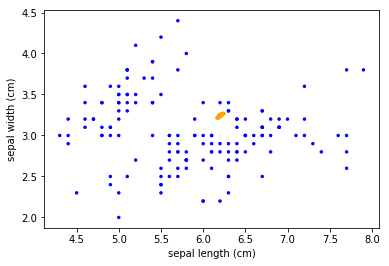

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure()
data_combined = pd.DataFrame(X_train, columns=feature_names)
data_combined['real_vs_fake'] = np.zeros(data_combined.shape[0])
data_combined = pd.concat((data_combined,fake_data ))
data_combined['real_vs_fake'] = data_combined['real_vs_fake'].astype(int)

# a scatter plot comparing num_children and num_pets
x1 = data_combined['sepal length (cm)']
y1 = data_combined['sepal width (cm)']
c = ['orange' if val==1 else 'blue' for val in data_combined['real_vs_fake']]
plt.scatter(x1, y1, c=c, label=c, s=6)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
#plt.legend()
plt.show()